In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:

import os
import scipy.ndimage as ndi
import torch

# import torchtrainers as tt
from webdataset import WebDataset, WebLoader
from ocropus4train import ocrhelpers as helpers
from ocropus4train import ocrmodels2 as models
import matplotlib.pyplot as plt
from random import randrange
from ocropus4train import nlbin

plt.rc("image", cmap="gray")
plt.rc("image", interpolation="nearest")


def RUN(x):
    print(x, ":", os.popen(x).read().strip())


RUN("date")
RUN("hostname")
RUN("nvidia-smi -L")
RUN("pwd")

if "GOPEN_VERBOSE" in os.environ:
    del os.environ["GOPEN_VERBOSE"]

date : Fri May 19 04:52:50 PDT 2023
hostname : sedna
nvidia-smi -L : GPU 0: NVIDIA RTX A6000 (UUID: GPU-75b6a74e-be17-239b-3a77-ded9498399aa)
pwd : /home/tmb/proj/ocropus4train


In [3]:
training_urls = "gs://ocro-iaa/segs/books-{000000..000653}-segs.tar"
batch_size = 4
mname = "seg_unet_v4"

In [4]:
from ocropus4train.ocraugment import maybe, normalize, noisify, threshold, distort


def affine_transform(image, matrix, output_shape=None, **kw):
    if image.ndim == 2:
        return ndi.affine_transform(image, matrix, output_shape=output_shape, **kw)
    elif image.ndim == 3:
        result = np.zeros(output_shape, dtype=image.dtype)
        for i in range(image.shape[2]):
            ndi.affine_transform(image[:, :, i], matrix, output_shape=output_shape[:2], output=result[:, :, i], **kw)
        return result


def random_patch(images, orders, size=512):
    h, w = images[0].shape[:2]
    for image in images:
        assert image.shape[:2] == (h, w)
    matrix = np.eye(3)
    matrix[:2, :2] += np.random.randn(2, 2) * 0.03
    # pick the translation so that we get a patch from anywhere within the image
    matrix[0, 2] = -random.uniform(-size / 2, h - size / 2)
    matrix[1, 2] = -random.uniform(-size / 2, w - size / 2)
    # compute the transform from the image to the patch
    matrix = np.linalg.inv(matrix)
    # apply the affine transform
    patches = []
    global last_xform 
    last_xform = locals()
    for image, order in zip(images, orders):
        output_shape = (size, size) if image.ndim == 2 else (size, size, image.shape[2])
        patch = affine_transform(
            image,
            matrix,
            output_shape=output_shape,
            order=order,
            mode="constant",
            cval=0,
        )
        patches.append(patch)
    return patches


def random_patch_simple(images, size=512):
    h, w = images[0].shape[:2]
    for image in images:
        assert image.shape[:2] == (h, w)
    y = randrange(0, h - size)
    x = randrange(0, w - size)
    patches = []
    for image in images:
        patches.append(image[y : y + size, x : x + size])
    return patches


def get_patches(sample, size=512):
    global last_img, last_seg
    image1 = sample["jpg"]
    assert image1.ndim == 2
    assert image1.dtype == np.uint8
    image1 = image1.astype(np.float32) / 255.0
    if maybe(0.1):  # FIXME only for testing
        binarized = nlbin.nlbin(image1)
        if maybe(0.2):
            binarized = (binarized > 0.5).astype(np.float32)
        # binarization sometimes changes image size slightly
        assert np.amax(np.abs(np.array(binarized.shape) - np.array(image1.shape))) <= 2
        # use ndi.affine_transform to make binarized exactly the same shape as image1
        image1 = ndi.affine_transform(
            binarized, np.eye(3), output_shape=image1.shape, order=0, mode="nearest"
        )
    if image1.shape[0] < size or image1.shape[1] < size:
        return
    wseg = sample["words.jpg"].clip(0, 3)
    lseg = sample["lines.jpg"].clip(0, 3)
    assert wseg.shape == lseg.shape, (wseg.shape, lseg.shape)
    # print("words, lines", wseg.shape, np.sum(wseg >= 1), np.sum(lseg >= 1))
    seg1 = np.zeros((wseg.shape[0], wseg.shape[1], 7), dtype=np.uint8)
    seg1[:, :, 1] = ndi.maximum_filter((wseg >= 1), 12)
    seg1[:, :, 2] = (wseg >= 2)
    seg1[:, :, 3] = (wseg >= 3)
    seg1[:, :, 4] = ndi.maximum_filter((lseg >= 1), 12)
    seg1[:, :, 5] = (lseg >= 2)
    seg1[:, :, 6] = (lseg >= 3)
    seg1[:, :, 0] = 1 - np.amax(seg1[:, :, 1:], axis=-1)
    if np.sum(seg1[:, :, 3]) == 0:
        # no words present
        print("no words", np.sum(seg1[:, :, 3]))
        return
    if np.sum(seg1[:, :, 6]) == 0:
        # no lines present
        print("no lines", np.sum(seg1[:, :, 3]))
        return
    for i in range(32):
        # TODO: add 90 degree rotations to augmentations
        # TODO: do something about isolated characters
        last_img, last_seg = img, seg = random_patch([image1, seg1], [1, 0], size=size)
        if np.sum(seg[:, :, 3]) == 0:
            # print("no words in patch", np.sum(seg[:, :, 3]))
            # global hack; hack = locals(); raise ValueError()
            continue
        if maybe(0.05):
            img = threshold(img)
        if maybe(0.5):
            img = distort(img)
        if maybe(0.5):
            img = normalize(img)
        if maybe(0.5):
            img = noisify(img)
        if maybe(0.1):
            sigma = random.uniform(0.5, 2.0)
            img = ndi.gaussian_filter(img, sigma)
        if np.amin(img) < 0 or np.amax(img) > 1:
            print("bad patch", np.amin(img), np.amax(img))
            continue
        yield (img, seg)

In [5]:
def expand_patches(src):
    for sample in src:
        # print(sample["__key__"])
        for result in get_patches(sample):
            yield result


def usm_patch(img):
    assert img.ndim == 2, img.shape
    assert img.dtype == np.float32, img.dtype
    assert np.amin(img) >= 0.0 and np.amax(img) <= 1.0
    img = img - ndi.gaussian_filter(img, 16.0, mode="nearest")
    if np.amin(img) >= 0.0:
        print("usm_patch: no negative values???")
        # fix this to make subsequent processing tages happy
        img = img - np.amin(img) + 0.001 * np.random.normal(size=img.shape)
        img = img.astype(np.float32)
    img = img.clip(-5.0, 5.0)
    return img


def img_tensor(img):
    assert img.ndim == 2, img.shape
    assert img.dtype == np.float32, img.dtype
    assert np.amax(img) < 10.0  # make sure it already got normalied somewhere
    return torch.tensor(img).unsqueeze(0)


def label_tensor(label):
    assert label.ndim == 3, label.shape
    assert label.shape[2] == 7, label.shape
    assert label.dtype == np.uint8, label.dtype
    return torch.tensor(label.transpose(2, 0, 1)).float()


def pipeline(ds):
    return (
        ds.decode("l8")
        .compose(expand_patches)
        .map_tuple(usm_patch)
        .map_tuple(img_tensor, label_tensor)
    )


training = (
    pipeline(WebDataset(training_urls, resampled=True).shuffle(10))
    .shuffle(1000)
    .batched(batch_size)
)

batch = next(iter(training))

torch.Size([4, 1, 512, 512]) torch.Size([4, 7, 512, 512])


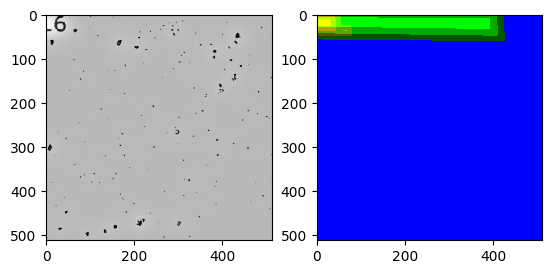

In [6]:
print(batch[0].shape, batch[1].shape)
subplot(121); imshow(batch[0][0, 0].numpy())
r = batch[1][0, 1:4].sum(axis=0).numpy().astype(np.float32) / 3.0
g = batch[1][0, 4:7].sum(axis=0).numpy().astype(np.float32) / 3.0
b = batch[1][0, 0].numpy().astype(np.float32())
color = np.stack([r, g, b], axis=-1)
subplot(122); imshow(color)

In [7]:
training_dl = WebLoader(
    training, batch_size=None, num_workers=4, pin_memory=True
).with_epoch(10000 // batch_size)

In [8]:
device = "cuda:0"
model = models.make(mname)
model.to(device)
model

MultiPixSegmenter(
  (model): Sequential(
    (0): SegInput()
    (1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Shortcut1(
        (f): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): Conv2d(96, 161, kernel_size=(3, 3),

In [9]:
lossfn = torch.nn.BCEWithLogitsLoss()
trainer = helpers.SegTrainer(model, masked=-1, device=device, lossfn=lossfn)
trainer.load_best()

loading ./models/seg_unet_v4-016-000135230.pth


loading ./models/seg_unet_v4-016-000135230.pth


True

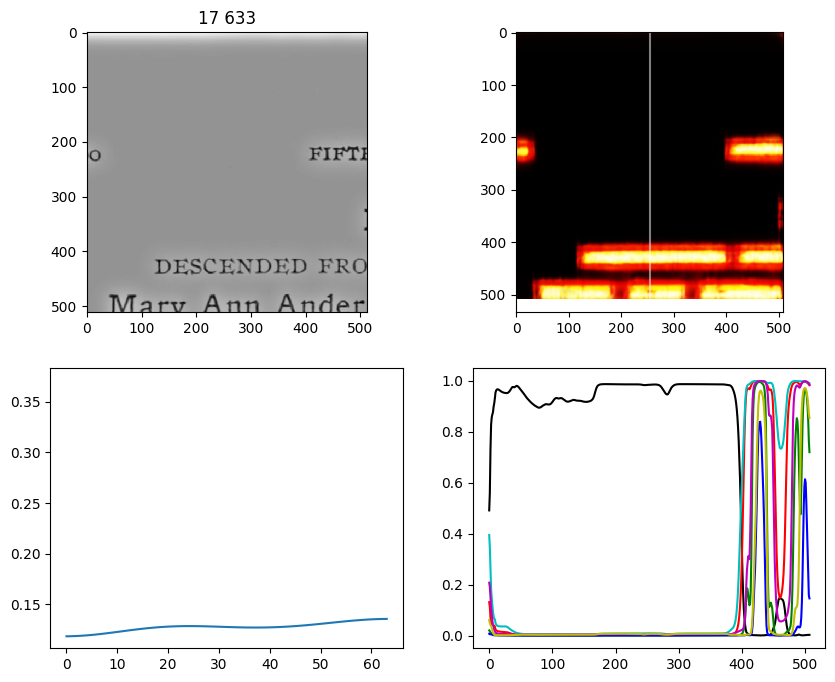

KeyboardInterrupt: 

In [10]:
trainer.train(training_dl, learning_rates=[1e-2] + [1e-3] * 15 + [3e-4] * 50 + [1e-4] * 200, every=10)

In [ ]:
trainer.lossfn